In [1]:
import pandas as pd
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# 读取 Excel 文件
df = pd.read_excel("E:\城市租房数据（贝壳链家）2024年\北京租房合并2411.xlsx")

# df.info()
df = df.replace("暂无数据", np.nan).dropna()
df = df.replace("暂无", np.nan).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2636 entries, 2 to 14991
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   页面网址       2636 non-null   object 
 1   标题         2636 non-null   object 
 2   房源编号       2636 non-null   object 
 3   维护时间       2636 non-null   object 
 4   租金         2636 non-null   object 
 5   标签         2636 non-null   object 
 6   租赁方式       2636 non-null   object 
 7   房屋类型       2636 non-null   object 
 8   面积         2636 non-null   object 
 9   楼层         2636 non-null   object 
 10  车位         2636 non-null   object 
 11  用电         2636 non-null   object 
 12  采暖         2636 non-null   object 
 13  租期         2636 non-null   object 
 14  看房         2636 non-null   object 
 15  朝向         2636 non-null   object 
 16  入住         2636 non-null   object 
 17  电梯         2636 non-null   object 
 18  用水         2636 non-null   object 
 19  燃气         2636 non-null   object 
 20  付款方式   

In [2]:
df.duplicated().sum()#统计重复数据情况
df.drop_duplicates(inplace=True)# 删除重复值

In [3]:
# ----------------------------
# # 1. 提取所在区（示例逻辑，需根据实际区名补充）
def extract_community(title):
    """
    从标题中提取小区名称，格式为 `整租/合租·小区名 户型...`
    示例：
    输入：整租·慧芝湖花园（三期） 1室2厅 南 → 输出：慧芝湖花园（三期）
    输入：合租·君御豪庭 3室2厅 南/北 → 输出：君御豪庭
    """
    if pd.isna(title):
        return None
    
    # 分割租赁方式和小区部分（以 "·" 分隔）
    if "·" in title:
        parts = title.split("·", 1)  # 分割成两部分
        community_part = parts[1].strip()
    else:
        # 处理无分隔符的情况（例如标题为 "整租静安城 1室1厅 南"）
        for prefix in ["整租", "合租"]:
            if title.startswith(prefix):
                community_part = title[len(prefix):].strip()
                break
        else:
            return None  # 无法识别格式
    
    # 提取小区名（去除后续户型信息，假设户型以数字开头）
    community = community_part.split()[0]
    return community

# 新增小区名列
df["位置"] = df["标题"].apply(extract_community)

# 提取租金和面积的数值部分
df['租金'] = df['租金'].str.extract('(\d+)').astype(int)
df['面积'] = df['面积'].str.extract('([\d.]+)').astype(float)

# 处理配套设施列，去除特殊字符并合并为单个空格分隔
df['配套设置'] = df['配套设置'].str.replace('_x000d_', '', regex=True).str.split().str.join(' ')
df['配套设置'] = df['配套设置'].str.replace('_x005f', '', regex=True).str.split().str.join(' ')
# ----------------------------
# 2. 判断地铁和阳台
# ----------------------------
# 标签列拆分并判断关键词
def check_subway(tags):
    if pd.isna(tags):
        return 0
    return 1 if "近地铁" in tags else 0

def check_balcony(tags):
    if pd.isna(tags):
        return 0
    return 1 if "独立阳台" in tags or "阳台" in tags else 0

df["地铁"] = df["标签"].apply(check_subway)
df["阳台"] = df["标签"].apply(check_balcony)

# 租赁方式
df["租赁方式"] = df["租赁方式"].map({"整租": 1, "合租": 0})


# 楼层拆分
# def classify_floor(floor_str):
#     # 处理包含"低/中/高楼层"的情况（如"中楼层/31层"）
#     if "低楼层" in floor_str:
#         return 1  # 低楼层=1
#     elif "中楼层" in floor_str:
#         return 2  # 中楼层=2
#     elif "高楼层" in floor_str:
#         return 3  # 高楼层=3
#     elif "地下室" in floor_str:
#         return 0  # 地下室=0
#     # 处理"4/6层"等纯数字格式
#     elif "/" in floor_str:
#         current_floor, total_floor = map(int, floor_str.replace("层", "").split("/"))
#         ratio = current_floor / total_floor
#         if ratio < 0.3:
#             return 1  # 低楼层
#         elif 0.3 < ratio < 0.7:
#             return 2  # 中楼层
#         elif ratio >= 0.7:
#             return 3  # 高楼层
#         else:
#             return 0  # 地下室
#     else:
#         return np.nan  # 异常数据标记为缺失
import numpy as np

def classify_floor(floor_str):
    # 处理所有地下室相关情况（包含'地下室'或'地下'）
    if '地下' in floor_str:
        return 0
    # 处理低、中、高楼层关键词
    elif '低楼层' in floor_str:
        return 1
    elif '中楼层' in floor_str:
        return 2
    elif '高楼层' in floor_str:
        return 3
#     处理带斜杠的格式（如'4/6层'或'-1/10层'）
    elif "/" in floor_str:
        current_floor, total_floor = map(int, floor_str.replace("层", "").split("/"))
        ratio = current_floor / total_floor
        if 0 < ratio <= 0.3:
            return 1  # 低楼层
        elif 0.3 < ratio < 0.7:
            return 2  # 中楼层
        elif ratio >= 0.7:
            return 3  # 高楼层
        else:
            return 0  # 地下室
    else:
        return np.nan  # 异常数据标记为缺失

# 提取楼层类型和总楼层数
df["楼层类型"] = df["楼层"].apply(classify_floor)

# 二元编码（有=1，无=0）
df["电梯"] = df["电梯"].map({"有": 1, "无": 0})
# 方法1：直接映射为二进制
df['用电_编码'] = df['用电'].map({'民电': 0, '商电': 1})
df['采暖_编码'] = df['采暖'].map({'自采暖': 0, '集中供暖': 1})

# 3. 提取房屋户型和装修
# ----------------------------
# 提取户型（正则表达式匹配 x室x厅x卫）
def extract_layout(house_type):
    if pd.isna(house_type):
        return None
    match = re.search(r"\d+室\d+厅\d+卫", house_type)
    return match.group() if match else None

# 判断是否精装修
def check_renovation(house_type):
    if pd.isna(house_type):
        return 0
    return 1 if "精装修" in house_type else 0

df["房屋户型"] = df["房屋类型"].apply(extract_layout)
df["房屋装修"] = df["房屋类型"].apply(check_renovation)

# 提取室、厅、卫数量（忽略↑↓符号）
# df["室"] = df["房屋户型"].str.extract(r"(\d+)室").astype(int)
# df["厅"] = df["房屋户型"].str.extract(r"(\d+)厅").astype(int)
# df["卫"] = df["房屋户型"].str.extract(r"(\d+)卫").astype(int)
df["室"] = df["房屋户型"].str.extract(r"(\d+)(?:室|居室|房间)").fillna(0).astype(float)
df["厅"] = df["房屋户型"].str.extract(r"(\d+)(?:厅|客厅)").fillna(0).astype(float)
df["卫"] = df["房屋户型"].str.extract(r"(\d+)(?:卫)").fillna(0).astype(float)




df = df.drop(columns=['页面网址','房源编号','标题', '标签', '房屋类型','楼层','租期','看房','入住',
                      '付款方式','押金_元','服务费_元','中介费_元','longitude','latitude','租房图片链接',
                      'wgs84_lng','wgs84_lat','车位','用水','燃气','用电','采暖',"房屋户型",'区县级'])

# ----------------------------
df

,维护时间,租金,租赁方式,面积,朝向,电梯,配套设置,位置,地铁,阳台,楼层类型,用电_编码,采暖_编码,房屋装修,室,厅,卫
2,2024-10-21,5600,1,148.00,南 北,1,洗衣机 空调 衣柜 电视 冰箱 热水器 床 暖气 宽带 天然气,东方太阳城,0,0,2,0,1,1,3.0,2.0,2.0
10,2024-11-10,22000,1,76.00,东南,1,洗衣机 空调 衣柜 电视 冰箱 热水器 床 暖气 宽带,新城国际,1,0,3,0,1,1,1.0,0.0,1.0
23,2024-11-06,2260,0,10.80,南,1,洗衣机 空调 衣柜 冰箱 热水器 床 暖气 宽带 天然气,中国铁建青秀尚城,1,1,2,0,1,1,0.0,0.0,0.0
28,2024-11-10,4590,1,37.42,北,1,洗衣机 空调 衣柜 冰箱 床 暖气 宽带 天然气,林肯公园,1,0,1,0,1,1,1.0,1.0,1.0
29,2024-11-08,6730,1,42.00,西南,0,洗衣机 空调 衣柜 电视 冰箱 热水器 床 暖气 宽带 天然气,德宝新园,1,0,3,0,1,1,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,2024-11-02,5500,1,60.25,南,1,洗衣机 空调 衣柜 电视 冰箱 热水器 床 暖气 宽带 天然气,文晟家园南里,1,1,2,0,1,1,1.0,1.0,1.0
14960,2024-11-01,2600,0,28.64,南,0,洗衣机 空调 衣柜 电视 冰箱 热水器 床 暖气 宽带 天然气,中东路121号院二区,0,1,1,0,1,1,0.0,0.0,0.0
14964,2024-11-11,5930,1,81.00,南,0,洗衣机 空调 衣柜 电视 冰箱 热水器 床 暖气 宽带 天然气,建材城东一里,0,0,2,0,1,1,2.0,1.0,1.0
14981,2024-11-10,6100,1,153.03,南 北,0,热水器 床 暖气,富力丹麦小镇D区,0,0,2,0,0,1,4.0,2.0,2.0


In [4]:
from sklearn.preprocessing import LabelEncoder
# 初始化编码器
le_orientation = LabelEncoder()
le_rental = LabelEncoder()

# 对“朝向”和“租赁方式”进行编码
df['朝向_编码'] = le_orientation.fit_transform(df['朝向'])
df['位置_编码'] = le_rental.fit_transform(df['位置'])
df = df.drop(columns=['朝向', '位置'])

In [5]:
# 将日期列转换为 datetime 类型
df["维护时间"] = pd.to_datetime(df["维护时间"])

# 转换为时间戳（浮点数）
df["维护时间_时间戳"] = df["维护时间"].astype("int64") // 10**9  # 转换为秒级时间戳
df["维护时间_时间戳"] = df["维护时间_时间戳"].astype("float64")
# 删除原始日期列
df = df.drop("维护时间", axis=1)

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
# 拆分错误项（如“床天然气”拆分为“床”和“天然气”）
df["配套设置"] = df["配套设置"].str.replace("床天然气", "床 天然气")
# 生成设施列表
facilities = ["洗衣机", "空调", "衣柜", "电视", "冰箱", "热水器", "床", "天然气"]
# 为每个设施生成二元特征
for facility in facilities:
    df[f"设施_{facility}"] = df["配套设置"].apply(lambda x: 1 if facility in x else 0)

# 3. 生成设施数量统计特征
df["配套设置数量"] = df["配套设置"].apply(len)

# 4. 分离特征和目标变量
X = df.drop(columns=["租金", "配套设置"])  # 特征矩阵（包含二元特征和数量统计）
y = df["租金"]  # 目标变量
# 删除原始日期列
df = df.drop("配套设置", axis=1)

In [7]:
df

,租金,租赁方式,面积,电梯,地铁,阳台,楼层类型,用电_编码,采暖_编码,房屋装修,...,维护时间_时间戳,设施_洗衣机,设施_空调,设施_衣柜,设施_电视,设施_冰箱,设施_热水器,设施_床,设施_天然气,配套设置数量
2,5600,1,148.00,1,0,0,2,0,1,1,...,1.729469e+09,1,1,1,1,1,1,1,1,31
10,22000,1,76.00,1,1,0,3,0,1,1,...,1.731197e+09,1,1,1,1,1,1,1,0,27
23,2260,0,10.80,1,1,1,2,0,1,1,...,1.730851e+09,1,1,1,0,1,1,1,1,28
28,4590,1,37.42,1,1,0,1,0,1,1,...,1.731197e+09,1,1,1,0,1,0,1,1,24
29,6730,1,42.00,0,1,0,3,0,1,1,...,1.731024e+09,1,1,1,1,1,1,1,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,5500,1,60.25,1,1,1,2,0,1,1,...,1.730506e+09,1,1,1,1,1,1,1,1,31
14960,2600,0,28.64,0,0,1,1,0,1,1,...,1.730419e+09,1,1,1,1,1,1,1,1,31
14964,5930,1,81.00,0,0,0,2,0,1,1,...,1.731283e+09,1,1,1,1,1,1,1,1,31
14981,6100,1,153.03,0,0,0,2,0,0,1,...,1.731197e+09,0,0,0,0,0,1,1,0,8


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2476 entries, 2 to 14991
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   租金        2476 non-null   int32  
 1   租赁方式      2476 non-null   int64  
 2   面积        2476 non-null   float64
 3   电梯        2476 non-null   int64  
 4   地铁        2476 non-null   int64  
 5   阳台        2476 non-null   int64  
 6   楼层类型      2476 non-null   int64  
 7   用电_编码     2476 non-null   int64  
 8   采暖_编码     2476 non-null   int64  
 9   房屋装修      2476 non-null   int64  
 10  室         2476 non-null   float64
 11  厅         2476 non-null   float64
 12  卫         2476 non-null   float64
 13  朝向_编码     2476 non-null   int32  
 14  位置_编码     2476 non-null   int32  
 15  维护时间_时间戳  2476 non-null   float64
 16  设施_洗衣机    2476 non-null   int64  
 17  设施_空调     2476 non-null   int64  
 18  设施_衣柜     2476 non-null   int64  
 19  设施_电视     2476 non-null   int64  
 20  设施_冰箱     2476 non-null   int

In [9]:
# 定义中英文列名映射字典
column_mapping = {
    # 基础信息
    '维护时间_时间戳': 'Maintenance_Date',
    '租金': 'Rent',
    '租赁方式': 'Rental_Type',
    '面积': 'Area',
    '电梯': 'Elevator',
    '位置_编码': 'Location',
    '朝向_编码': 'Toward',
    '地铁': 'Subway',
    '阳台': 'Balcony',
    
    # 楼层相关
    '楼层类型': 'Floor_Type',
    
    # 能源相关
    '用电_编码': 'Electricity',
    '采暖_编码': 'Heating',
    
    # 设施相关
    '设施_洗衣机': 'Facility_Washing_Machine',
    '设施_空调': 'Facility_Air_Conditioner',
    '设施_衣柜': 'Facility_Wardrobe',
    '设施_电视': 'Facility_TV',
    '设施_冰箱': 'Facility_Refrigerator',
    '设施_热水器': 'Facility_Water_Heater',
    '设施_床': 'Facility_Bed',
    '设施_天然气': 'Facility_Natural_Gas',
    '配套设置数量': 'Facility_num',
    
    # 房屋信息
    '房屋装修': 'Renovation',
    '室': 'Bedroom_num',
    '厅': 'Living_Room_num',
    '卫': 'Bathroom_num'
}

# 重命名列名
df = df.rename(columns=column_mapping)

# 保存为Excel文件
df.to_excel("processed_rental_data_bj.xlsx", index=False)

In [10]:
import pandas as pd

# 假设 features 是 DataFrame
print("缺失值统计：")
print(df.isnull().sum())

# 检查整个 DataFrame 是否有缺失值
if df.isnull().any().any():
    print("数据中存在缺失值！")
else:
    print("数据中无缺失值。")

缺失值统计：
Rent                        0
Rental_Type                 0
Area                        0
Elevator                    0
Subway                      0
Balcony                     0
Floor_Type                  0
Electricity                 0
Heating                     0
Renovation                  0
Bedroom_num                 0
Living_Room_num             0
Bathroom_num                0
Toward                      0
Location                    0
Maintenance_Date            0
Facility_Washing_Machine    0
Facility_Air_Conditioner    0
Facility_Wardrobe           0
Facility_TV                 0
Facility_Refrigerator       0
Facility_Water_Heater       0
Facility_Bed                0
Facility_Natural_Gas        0
Facility_num                0
dtype: int64
数据中无缺失值。


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rent,2476.0,5.783424e+03,8023.206051,7.020000e+02,2.500000e+03,3.600000e+03,5.800000e+03,1.500000e+05
Rental_Type,2476.0,7.500000e-01,0.433100,0.000000e+00,7.500000e-01,1.000000e+00,1.000000e+00,1.000000e+00
Area,2476.0,7.859044e+01,64.501467,5.500000e+00,3.047750e+01,7.100000e+01,9.800000e+01,5.720000e+02
Elevator,2476.0,5.395800e-01,0.498532,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Subway,2476.0,3.957997e-01,0.489121,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Balcony,2476.0,6.340872e-02,0.243746,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Floor_Type,2476.0,2.092488e+00,0.806995,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
Electricity,2476.0,1.575121e-02,0.124537,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Heating,2476.0,8.210824e-01,0.383361,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Renovation,2476.0,7.766559e-01,0.416571,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## 可视化

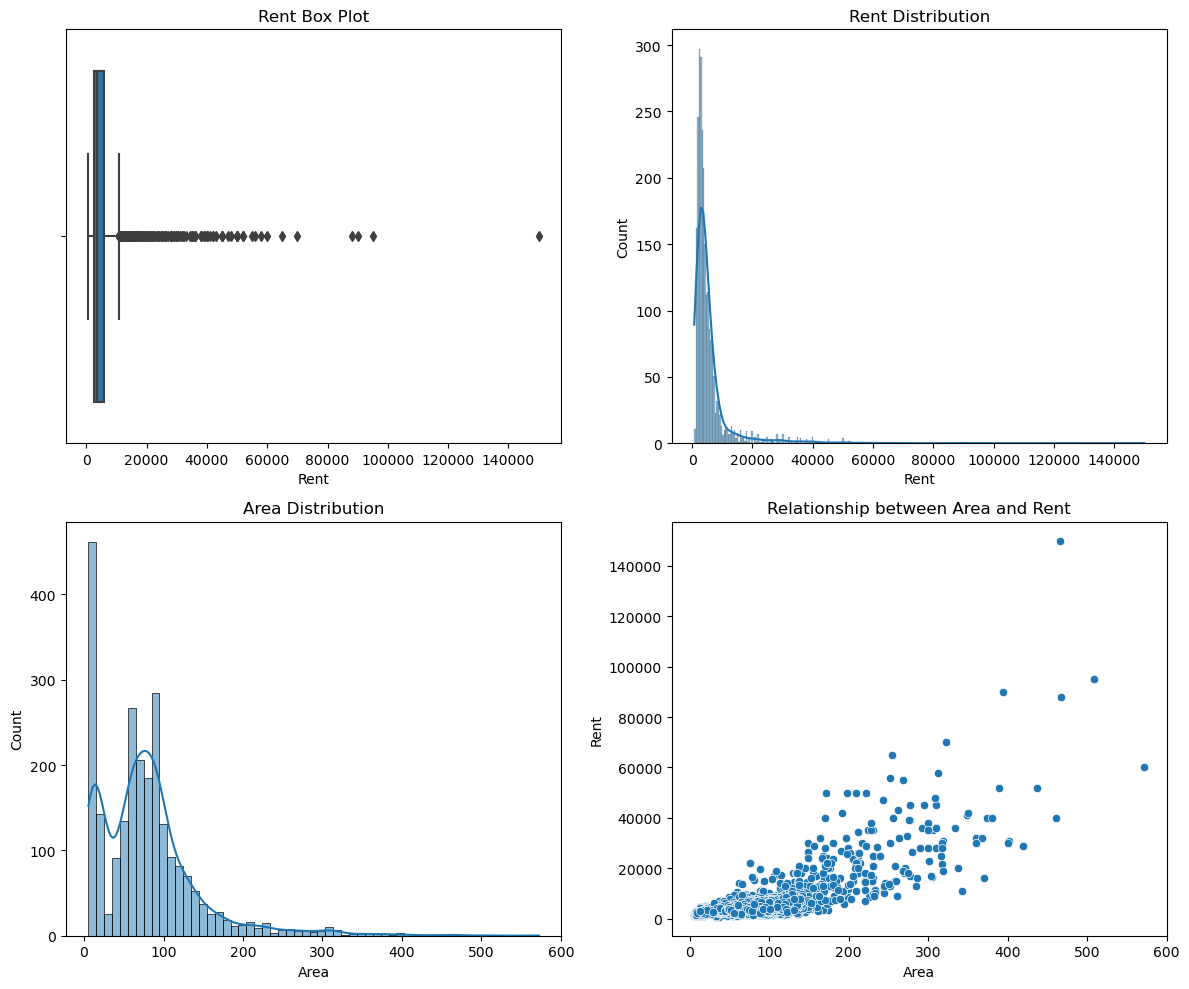

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建一个2x2的子图网格
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 绘制第一个图：箱线图
sns.boxplot(data=df, x='Rent', ax=axes[0, 0])
axes[0, 0].set_title('Rent Box Plot')

# 绘制第二个图：房屋租金直方图
sns.histplot(data=df, x='Rent', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Rent Distribution')

# 绘制第三个图：房屋面积直方图
sns.histplot(data=df, x='Area', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Area Distribution')

# 绘制第四个图：散点图
sns.scatterplot(x=df['Area'], y=df['Rent'], ax=axes[1, 1])
axes[1, 1].set_title('Relationship between Area and Rent')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

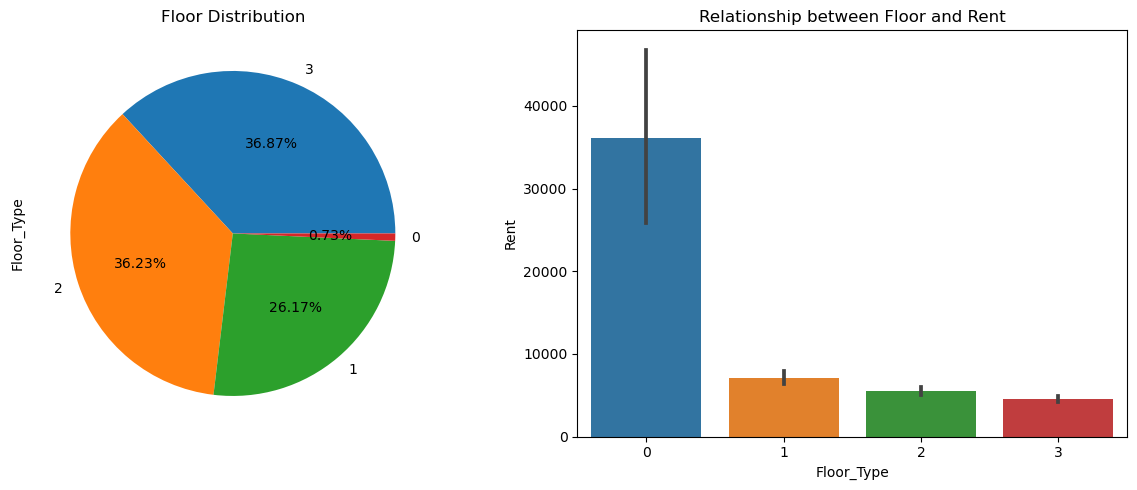

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Plot 1: Bar plot of House Orientation vs House Rent
# sns.barplot(data=df, x='House Orientation', y='Rent', ax=axes[0, 0])
# axes[0, 0].set_title('Relationship between House Orientation and Rent')

# Plot 2: Pie chart of Floor value counts
df['Floor_Type'].value_counts().plot(kind='pie', autopct='%.2f%%', ax=axes[0])
axes[0].set_title('Floor Distribution')

# Plot 3: Bar plot of Floor vs House Rent
sns.barplot(data=df, x='Floor_Type', y='Rent', ax=axes[1])
axes[1].set_title('Relationship between Floor and Rent')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

## 特征工程

In [14]:
# 特征筛选
# new_df = df[['Rent','Rental_Type','Area','Bedroom_num','Living_Room_num','Bathroom_num']]
new_df = df[['Maintenance_Date','Rent','Rental_Type', 'Area','Elevator', 'Location','Toward','Subway','Balcony','Floor_Type','Electricity',
'Heating','Facility_Washing_Machine', 'Facility_Air_Conditioner','Facility_Wardrobe','Facility_TV','Facility_Refrigerator','Facility_Water_Heater','Facility_Bed',
'Facility_Natural_Gas','Facility_num', 'Renovation', 'Bedroom_num','Living_Room_num','Bathroom_num']]

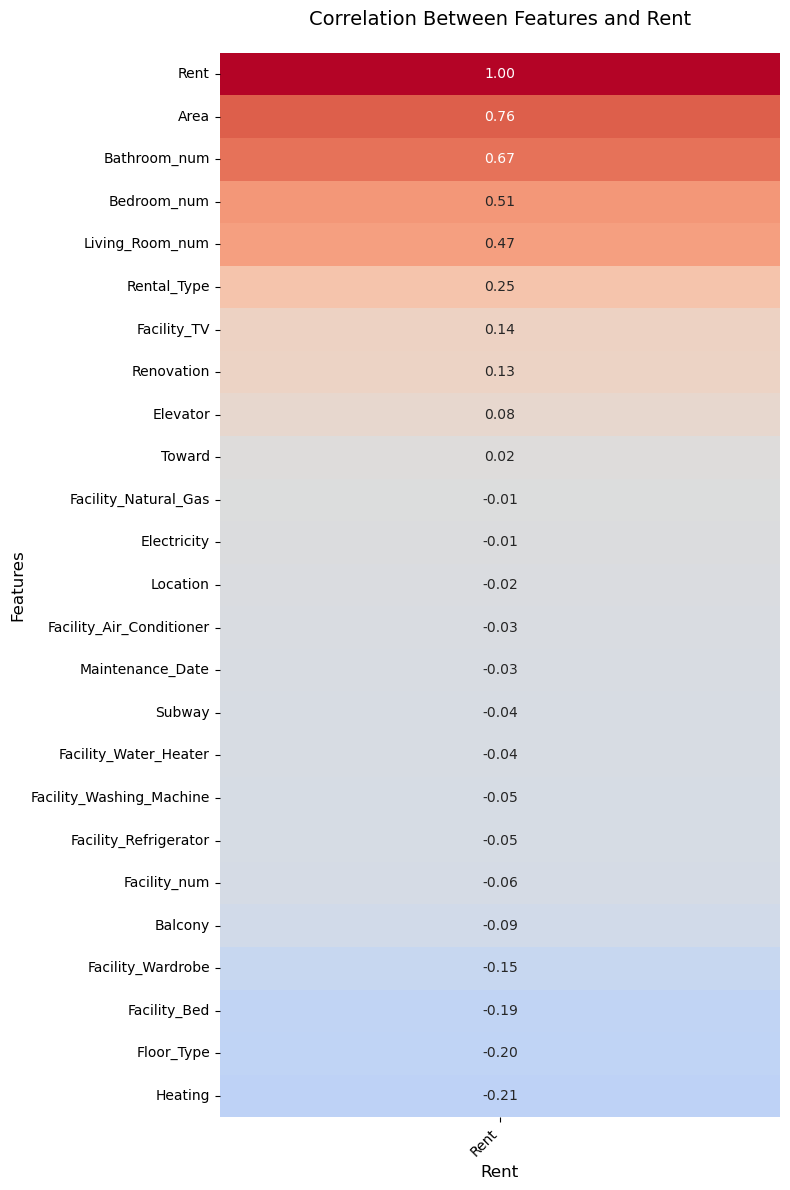

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算所有特征与租金的相关性
correlation = new_df.corr()[["Rent"]].sort_values(by="Rent", ascending=False)

# 设置热力图尺寸和样式
plt.figure(figsize=(8, 12))  # 增大高度以容纳更多行
sns.heatmap(
    correlation,  # 直接使用排序后的相关性数据
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},  # 调大注释字体
    cbar=False,  # 移除颜色条以节省空间
    vmin=-1,
    vmax=1
)

# 优化标签显示
plt.title("Correlation Between Features and Rent", fontsize=14, pad=20)
plt.xlabel("Rent", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(rotation=45, ha="right")  # 旋转x轴标签
plt.yticks(rotation=0)  # 保持y轴标签水平

# 自动调整布局防止截断
plt.tight_layout()
plt.show()

In [16]:
# 加载数据文件并对数据进行处理
# df = new_df[['Rent','Rental_Type', 'Area','Elevator','Subway','Facility_TV',
#  'Bedroom_num','Living_Room_num','Bathroom_num']]
df = new_df[['Maintenance_Date','Rent','Rental_Type', 'Area','Elevator', 'Location','Toward','Subway','Balcony','Floor_Type','Electricity',
'Heating','Facility_Washing_Machine', 'Facility_Air_Conditioner','Facility_Wardrobe','Facility_TV','Facility_Refrigerator','Facility_Water_Heater','Facility_Bed',
'Facility_Natural_Gas','Facility_num', 'Renovation', 'Bedroom_num','Living_Room_num','Bathroom_num']]

## 多重线性回归

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tools import add_constant
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
# 拆分自变量（X）和因变量（y）
X = df.drop('Rent', axis=1)  
y = df['Rent']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 取出需要的特征列，并进行规范化处理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_const = add_constant(X_train_scaled)
X_test_const = add_constant(X_test_scaled)

model = sm.OLS(y_train, X_train_const).fit()

# 计算均方误差 (MSE)
y_pred = model.predict(X_test_const)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("测试集上 OLS 模型均方误差 (MSE)：", mse)
print("测试集上 OLS 模型平均绝对误差 (MAE)：", mae)
print("测试集上 OLS 模型决定系数 (R2)：", r2)


测试集上 OLS 模型均方误差 (MSE)： 13975912.380735638
测试集上 OLS 模型平均绝对误差 (MAE)： 2141.3318193057853
测试集上 OLS 模型决定系数 (R2)： 0.7311672742214437


## ridge回归

In [25]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============ 1. 准备数据 ============
# 假设原始 DataFrame 叫做 df
# 请务必确保 'Rent' 是你的目标列名称，并且不再放进特征里
X = df.drop(columns=['Rent'])   # 移除目标列
y = df['Rent']

# ============ 2. 划分训练集和测试集 ============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# ============ 3. 对特征进行标准化 ============
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 用训练集“拟合+变换”
X_test_scaled = scaler.transform(X_test)        # 用训练集的均值方差来变换测试集

# ============ 4. 网格搜索超参数 alpha ============
ridge = Ridge()  # 不需要手动 add_constant，Ridge 会自带截距
params = {
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
}

grid_model = GridSearchCV(ridge, params, cv=5, scoring='r2')
grid_model.fit(X_train_scaled, y_train)

print("Best CV Score (on training folds):", grid_model.best_score_)
print("Best Params:", grid_model.best_params_)

# ============ 5. 用最佳 alpha 在训练集上重新训练 ============
best_alpha = grid_model.best_params_['alpha']
reg = Ridge(alpha=best_alpha)
reg.fit(X_train_scaled, y_train)

# ============ 6. 在测试集上做预测并评估 ============
y_pred = reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ridge模型均方误差 (MSE)：", mse)
print("Ridge模型平均绝对误差 (MAE)：", mae)
print("Ridge模型决定系数 (R2)：", r2)


Best CV Score (on training folds): 0.6696110907783825
Best Params: {'alpha': 10}
Ridge模型均方误差 (MSE)： 13936093.659156777
Ridge模型平均绝对误差 (MAE)： 2121.577082180615
Ridge模型决定系数 (R2)： 0.7319332045712803


## 决策树回归

In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)# 忽略 DeprecationWarning 警告
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 假设 df 为你的完整数据，其中 'Rent' 是目标列
# 并且 features = df.drop(columns=['Rent']) 等价
X = features  # 你的特征
y = df['Rent']

# 1. 先划分训练集和测试集（若你已在外部拆分，可省略这步）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# 2. 定义参数网格（删除过于极端的取值，或适度收缩范围）
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],    # None 表示不限制深度，但可能过拟合
    'min_samples_split': [2, 5, 10, 20, 30],  # 去掉了 min_samples_split=1 等非法/极端值
    'min_samples_leaf': [1, 2, 5, 10],        # min_samples_leaf=1 也容易过拟合，但可对比
    'max_features': [None, 'sqrt', 'log2']
}

# 3. 创建决策树回归模型
regressor = DecisionTreeRegressor(random_state=42)

# 4. 使用 GridSearchCV 来寻找最佳参数组合（在训练集上做 5 折交叉验证）
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # 也可用 'r2' 等
    n_jobs=-1  # 并行加速，可选
)

# 5. 在训练集上进行网格搜索
grid_search.fit(X_train, y_train)

# 6. 输出最佳参数组合和在交叉验证中的得分
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("最佳参数组合:", best_params)

# 7. 使用最佳参数组合的模型，在测试集上进行预测
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)

# 8. 评估模型在测试集上的性能
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("决策回归树模型均方误差 (MSE):", mse)
print("决策回归树模型平均绝对误差 (MAE):", mae)
print("决策回归树模型R^2分数:", r2)

最佳参数组合: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
决策回归树模型均方误差 (MSE): 68298.43548387097
决策回归树模型平均绝对误差 (MAE): 28.85483870967742
决策回归树模型R^2分数: 0.9986862500223708


## lasso回归

In [26]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============ 1. 确保目标列不在特征中 ============
# 假设 df 为你的完整数据，其中 'Rent' 是目标列
X = df.drop(columns=['Rent'])   # 移除目标列，剩下的才是特征
y = df['Rent']

# ============ 2. 划分训练集和测试集 ============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# ============ 3. 使用 Pipeline 封装“标准化 + Lasso” ============
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # 第一步：特征标准化
    ('lasso', Lasso())             # 第二步：Lasso 回归
])

# ============ 4. 定义待搜索的超参数空间 ============
params = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

# ============ 5. 在训练集上做网格搜索（交叉验证） ============
grid_model = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=5,              # 5 折交叉验证
    scoring='r2'
)
grid_model.fit(X_train, y_train)

print("Best CV Score (on training folds):", grid_model.best_score_)
print("Best Params:", grid_model.best_params_)

# ============ 6. 使用最佳参数模型，在测试集上评估 ============
best_model = grid_model.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Lasso回归模型均方误差 (MSE)：", mse)
print("Lasso回归模型平均绝对误差 (MAE)：", mae)
print("Lasso回归模型决定系数 (R2)：", r2)

Best CV Score (on training folds): 0.6693682107433132
Best Params: {'lasso__alpha': 5}
Lasso回归模型均方误差 (MSE)： 13935012.084228842
Lasso回归模型平均绝对误差 (MAE)： 2132.272299943507
Lasso回归模型决定系数 (R2)： 0.7319540091333074


## 随机森林回归

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 假设 df 为你的完整数据，其中 'Rent' 是目标列
# 并且 features = df.drop(columns=['Rent']) 等价
X = features
y = df['Rent']

# 1. 先划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# 2. 创建随机森林模型 (可启用 oob_score=True 做袋外评估)
rf_model = RandomForestRegressor(
    oob_score=True, 
    random_state=42
)

# 3. 创建超参数字典 (适度缩小范围，避免过度拟合)
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],         # 原来有 10, 15；可尝试去掉过大的值
    'min_samples_split': [5, 10, 20], # 避免过小值(如2)可能让树过深
    'min_samples_leaf': [2, 4, 5]     # 增大 min_samples_leaf，抑制过拟合
}

# 4. 创建网格搜索模型 (在训练集上做5折交叉验证)
grid_model = GridSearchCV(
    estimator=rf_model,
    param_grid=params,
    cv=5, 
    scoring='r2',
    n_jobs=-1  # 并行加速，可选
)

# 5. 将模型拟合到训练数据上
grid_model.fit(X_train, y_train)

# 6. 打印最佳超参数和对应的R^2分数(基于训练集交叉验证)
print("Best CV Score:", grid_model.best_score_)
print("Best Params:", grid_model.best_params_)

# 7. 使用最佳超参数创建最终模型，并在训练集上训练
best_params = grid_model.best_params_
rf_reg = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    oob_score=True,
    random_state=42
)

rf_reg.fit(X_train, y_train)

# 8. 预测并评估模型在“测试集”上的性能
y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("随机森林模型均方误差 (MSE):", mse)
print("随机森林模型平均绝对误差 (MAE):", mae)
print("随机森林模型R^2分数:", r2)

# 如果启用了 oob_score=True，可以查看袋外分数
print("随机森林袋外得分(OOB Score):", rf_reg.oob_score_)


Best CV Score: 0.9703702143189311
Best Params: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
随机森林模型均方误差 (MSE): 187211.22331230875
随机森林模型平均绝对误差 (MAE): 32.85716512038582
随机森林模型R^2分数: 0.9963989110629544
随机森林袋外得分(OOB Score): 0.9563028155711372
